In [1]:
from os.path import dirname, join, abspath
from pyrep import PyRep
from pyrep.robots.arms.baxter import BaxterLeft, BaxterRight
from pyrep.robots.end_effectors.baxter_gripper import BaxterGripper
from pyrep.objects.dummy import Dummy
from pyrep.objects.shape import Shape
from pyrep.const import ObjectType, TextureMappingMode
from pyrep.objects.joint import Joint
from pyrep.objects.object import Object
from pyrep.objects.vision_sensor import VisionSensor
import transforms3d.quaternions as quaternions
import transforms3d.euler as euler

import pandas as pd 
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
import pickle
import pywt
from numpy import random
from pyrep.backend import sim

# random texture
import glob
import random
import imgaug.augmenters as iaa

import os

try:  
    os.mkdir("images") 
    os.mkdir("test") 
    os.mkdir("test/images") 
except OSError as error:  
    print(error)  
    

seq = iaa.Sequential([iaa.AdditiveGaussianNoise(scale=0.03)])

[Errno 17] File exists: 'images'


## Loading vrep scene file and initialization

In [2]:
SCENE_FILE = 'dvrk_rendering_feature_opt.ttt'
#SCENE_FILE = 'scene_baxter_pick_and_pass.ttt'
pr = PyRep()

pr.launch(SCENE_FILE, headless=False)
pr.start()

L1_visual = Shape("L1_visual_TOOL1")
L1 = L1_visual.ungroup()[0]
L2_visual = Shape("L2_visual_TOOL1")
L2 = L2_visual.ungroup()[0]
L3_dx_visual = Shape("L3_dx_visual_TOOL1")
L3_dx = L3_dx_visual.ungroup()[0]
L3_sx_visual = Shape("L3_sx_visual_TOOL1")
L3_sx = L3_sx_visual.ungroup()[0]

default_L1_color = L1.get_color()
default_L2_color = L2.get_color()
default_L3_color = L3_dx.get_color()

cam_center = Dummy("cam_center")
cam_center_near = Dummy("cam_near")
init_point = Dummy("init_point")
init_point_pos = init_point.get_position()

dx = Dummy("IK_target_dx_PSM1")
sx = Dummy("IK_target_sx_PSM1")

EE = Dummy("EE_virtual_TOOL1")

l_cam = VisionSensor("Vision_sensor_left")
init_cam_position = l_cam.get_position()
init_cam_pose = l_cam.get_pose()
track_cam = VisionSensor("tracking_cam")

cam_pos = cam_center.get_position()
current_pos = sx.get_position()

features = [Shape("f0"),Shape("f1"),Shape("f2"),Shape("f3"),Shape("f4"),Shape("f5"),
           Shape("f6"),Shape("f7"),Shape("f8"),Shape("f9"),Shape("f10"),Shape("f11"),
           Shape("f12"),Shape("f13"),Shape("f14"),Shape("f15"),Shape("f16"),Shape("f17"),
           Shape("f18"),Shape("f19"),Shape("f20"),Shape("f21"),Shape("f22"),Shape("f23"),
           Shape("f24"),Shape("f25"),Shape("f26"),Shape("f27"),Shape("f28"),Shape("f29"),
            Shape("f30"),Shape("f31")]

bg_list = glob.glob("sample_bg/*.jpg")

pr.step()

# set to cam center
sx.set_position(cam_center_near.get_position())
dx.set_position(cam_center_near.get_position())
pr.step()
init_sx_quat = sx.get_quaternion()
init_dx_quat = dx.get_quaternion()

# set to init pose

sx.set_quaternion(init_sx_quat)
dx.set_quaternion(init_dx_quat)
pr.step()

## Functions for data generation

In [3]:


def get_pix_from_angle(angle,resolution,fov):
    pixel = 0.5*resolution*(1+np.tan(angle)/np.tan(0.5*fov) )
    return np.rint(pixel)

def get_coor_by_projection(v_pos, x_resolution = 640, y_resolution = 480, fov = np.pi/3):
    
    # find the field of view for x and y axis
    if (x_resolution/y_resolution) > 1:
        fov_x = fov
        fov_y = 2 * np.arctan(np.tan(fov/2) / (x_resolution/y_resolution))
    else:
        fov_x = 2 * np.arctan(np.tan(fov/2) / (x_resolution/y_resolution))
        fov_y = fov
        
    xRel = v_pos[0]
    yRel = v_pos[1]
    zRel = v_pos[2]
    x = get_pix_from_angle(np.arctan2(-xRel,zRel),x_resolution,fov_x)
    y = get_pix_from_angle(np.arctan2(-yRel,zRel),y_resolution,fov_y)
    return (int(x),int(y))

    
    
def add_data(features, cam, data_dict, count):
    image_name = "images/" + str(count) + ".png"
    image = cam.capture_rgb()
    image = seq(images=image)
    image[image > 1] = 1
    image[image < 0] = 0
    n_feature = len(features)
    joints = np.zeros((n_feature,3))
    feature_to_delete = []
    for i in range(n_feature):
        if True: 
            x,y = get_coor_by_projection(features[i].get_position(l_cam))
            joints[i,:] = np.array([i,x,y])
        else:
            feature_to_delete.append(i)
    # delete no visiable features
    #joints = np.delete(joints,feature_to_delete,0)            
        
    data_dict[image_name] = joints.astype(int)
    plt.imsave(image_name,image)
    return data_dict

def extract_edge(img):
    img = img * 255
    img = np.uint8(img)
    edges = cv2.Canny(img,100,200)
    return edges


def set_light_position(position:list):
    Light = sim.simGetObjectHandle('Light')
    sim.simSetObjectPosition(Light,-1,position)
    pr.step()
    
def get_light_position():
    Light = sim.simGetObjectHandle('Light')
    return sim.simGetObjectPosition(Light,-1)

def random_lighting_position():
    l_position = get_light_position() + np.random.normal(loc=0.0, scale=[0.005,0.005,0.005], size=(3))
    set_light_position(list(l_position))
    
def random_cam_position():
    #position = l_cam.get_position() + np.random.normal(loc=0.0, scale=[0.001,0.001,0.001], size=(3))
    #l_cam.set_position(position)
    position = l_cam.get_pose() + np.random.normal(loc=0.0, scale=[0.003], size=(7))
    l_cam.set_pose(position)
    pr.step()
    
def reset_light():
    Light = sim.simGetObjectHandle('Light')
    sim.simSetObjectPosition(Light,-1,list(init_cam_position))
    pr.step()
    
def reset_cam():
    l_cam.set_pose(list(init_cam_pose))
    pr.step()
    
    
def set_background(filename):
    ConcreteFloor = Shape("ConcreteFloor")
    
    TEX_KWARGS = {
        'mapping_mode': TextureMappingMode.PLANE,
        'repeat_along_u': True,
        'repeat_along_v': True,
    }
    text_ob, texture = pr.create_texture(filename)
    ConcreteFloor.set_texture(texture, **TEX_KWARGS)
    pr.step()
    
def set_tool_texture(part, filename):
    TEX_KWARGS = {
        'mapping_mode': TextureMappingMode.PLANE,
        'repeat_along_u': True,
        'repeat_along_v': True,
        'uv_scaling': [0.005, 0.005]
    }
    text_ob, texture = pr.create_texture(filename)
    part.set_texture(texture, **TEX_KWARGS)
    pr.step()
    
def reset_color():
    L1.set_color(default_L1_color)
    L2.set_color(default_L2_color)
    L3_dx.set_color(default_L3_color)
    L3_sx.set_color(default_L3_color)
    pr.step()

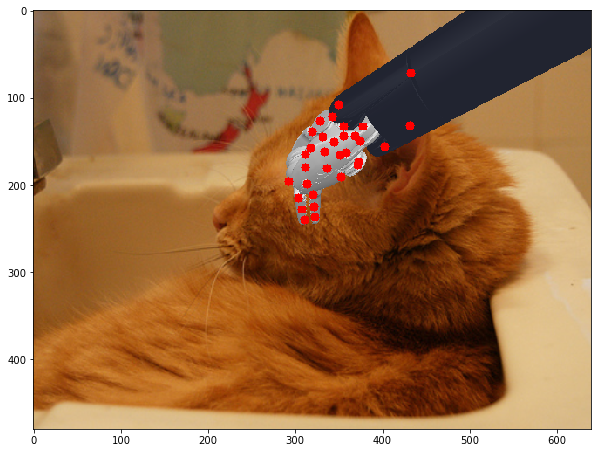

In [4]:
plt.figure(figsize = (10,10))
set_background(bg_list[0])
img = l_cam.capture_rgb()

for f in features:
    x,y = get_coor_by_projection(f.get_position(l_cam))
    img = cv2.circle(img,(x,y), 5, (1,0,0), -1)
plt.imshow(img)

## Generating data

In [5]:
# random texture
import glob
import random
sx_pose = np.load("sx_pose.npy")
dx_pose = np.load("dx_pose.npy")
print(sx_pose.shape)
data_dict = {}
count = 0

(3830, 7)


In [6]:
for i in range(sx_pose.shape[0]):

    print(i)

        
    sx.set_pose(sx_pose[i])
    dx.set_pose(dx_pose[i])
    if i%10 == 0:
        reset_light()
    random_lighting_position()
    reset_color()
    reset_cam()
    set_background(bg_list[random.randint(0,len(bg_list)-1)])
    pr.step()
    data_dict = add_data(features, l_cam, data_dict,count)
    count += 1
    time.sleep(0.01)
    for n in range(5):
        random_lighting_position()
        random_cam_position()
        random_color = default_L1_color + np.random.normal(loc = 0.0, scale = 0.03, size = 3)
        random_color = random_color.tolist()
        L1.set_color(random_color)
        random_color = default_L2_color + np.random.normal(loc = 0.0, scale = 0.03, size = 3)
        random_color = random_color.tolist()
        L2.set_color(random_color)
        L3_dx.set_color(random_color)
        L3_sx.set_color(random_color)
        
        pr.step()
        data_dict = add_data(features, l_cam, data_dict,count)
        count += 1
        time.sleep(0.01)

0


/home/jingpei/.local/lib/python3.7/site-packages/pyrep/objects/object.py:656: UserWarning: Object (25, 'Light') has ObjectType.LIGHT, which is not supported
  'which is not supported'.format(handle, name, type))
/home/jingpei/anaconda3/envs/pyrep/lib/python3.7/site-packages/imgaug/augmenters/base.py:38: SuspiciousMultiImageShapeWarning: You provided a numpy array of shape (480, 640, 3) as a multi-image augmentation input, which was interpreted as (N, H, W). The last dimension however has value 1 or 3, which indicates that you provided a single image with shape (H, W, C) instead. If that is the case, you should use e.g. augmenter(image=<your input>) or augment_image(<your input>) -- note the singular 'image' instead of 'imageS'. Otherwise your single input image will be interpreted as multiple images of shape (H, W) during augmentation.
  category=SuspiciousMultiImageShapeWarning)


1
2
3
4


In [7]:
filename = 'data'
outfile = open(filename,'wb')
pickle.dump(data_dict,outfile)
outfile.close()

pr.shutdown()

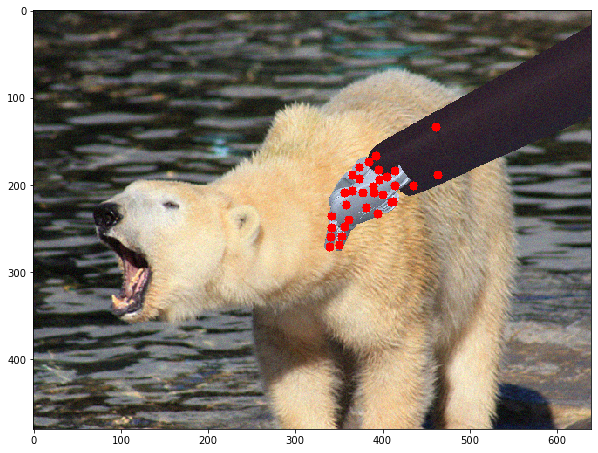

In [10]:
# check saved data
filename = 'data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

plt.figure(figsize = (10,10))

img_file = "images/8.png"
img = cv2.imread(img_file)
for i in data_dict[img_file]:
    img = cv2.circle(img,tuple(i[1:]), 5, (0,0,255), -1)
    
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
#plt.show()